In [ ]:
# NB! Heavily inspired by: https://www.analyticsvidhya.com/blog/2021/05/bitcoin-price-prediction-using-recurrent-neural-networks-and-lstm/

Necessary imports:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Preprocessing
We start by reading the downloaded time series with Pandas. The data has invalid price values, indicated by ".", so we have to remove these and impose the prices to be numeric again.

In [5]:
df = pd.read_csv('../Tidsrekker/CBLTCUSD.csv', date_parser = True)
# Sort out invalid price
df['CBLTCUSD'] = df['CBLTCUSD'][~(df['CBLTCUSD'] == '.' )]
df['CBLTCUSD'] = pd.to_numeric(df['CBLTCUSD'])

df.tail()

,DATE,CBLTCUSD
1822,2021-09-23,164.05
1823,2021-09-24,152.30
1824,2021-09-25,151.04
1825,2021-09-26,150.55
1826,2021-09-27,145.34


Here, we split the data in a training and testing DataFrame. We also drop the actual dates from the training data.

In [6]:
n = len(df)
train_df = df[0:int(n*0.9)] # df[0:int(n*0.7)]
test_df = df[int(n*0.9):] # df[int(n*0.9):]

df_train = train_df.drop('DATE', axis=1)
test_df.head()

,DATE,CBLTCUSD
1644,2021-03-29,194.12
1645,2021-03-30,195.58
1646,2021-03-31,197.58
1647,2021-04-01,202.91
1648,2021-04-02,212.00


In [23]:
test_df.describe()

,CBLTCUSD
count,183.000000
mean,191.217869
std,60.375852
min,107.350000
25%,144.990000
50%,176.900000
75%,216.205000
max,389.970000


In [22]:
df_test_new.tail()

,DATE,CBLTCUSD
200,2021-10-15,189.50
201,2021-10-16,186.08
202,2021-10-17,183.80
203,2021-10-18,185.68
204,2021-10-19,188.61


The data is normalized with Keras' MinMaxScaler so it's ready to be passed into the network.

In [7]:
scaler = MinMaxScaler()
df_train = scaler.fit_transform(df_train)
df_train

array([[0.00098342],
       [0.00092723],
       [0.00101152],
       ...,
       [0.50778309],
       [0.50823265],
       [0.50834504]])

Pass inputs parameters properly to be inserted to model

In [8]:
X_train = [] 
Y_train = []
for i in range(60, df_train.shape[0]):
     X_train.append(df_train[i-60:i])
     Y_train.append(df_train[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_train.shape

(1584, 60, 1)

# Building the model
Here we state the LSTM model. It has 4 layers with one droput and one Dense layer

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
# Initialize RNN
model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
# model.add(Dropout(0.3))
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
# model.add(Dropout(0.4))
model.add(LSTM(units = 120, activation = 'relu'))
# model.add(Dropout(0.5))
model.add(Dense(units =1))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               96480     
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 178,761
Trainable params: 178,761
Non-trainable params: 0
__________________________________________________

# Fitting the model

In [10]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
NUM_EPOCH = 20
history= model.fit(X_train, Y_train, epochs = NUM_EPOCH, batch_size = 128, validation_split=0.20)

Epoch 1/20
10/10 [==============================] - 8s 371ms/step - loss: 0.0424 - val_loss: nan
Epoch 2/20
10/10 [==============================] - 3s 262ms/step - loss: 0.0158 - val_loss: nan
Epoch 3/20
10/10 [==============================] - 2s 235ms/step - loss: 0.0090 - val_loss: nan
Epoch 4/20
10/10 [==============================] - 2s 249ms/step - loss: 0.0073 - val_loss: nan
Epoch 5/20
10/10 [==============================] - 2s 234ms/step - loss: 0.0062 - val_loss: nan
Epoch 6/20
10/10 [==============================] - 2s 244ms/step - loss: 0.0051 - val_loss: nan
Epoch 7/20
10/10 [==============================] - 2s 247ms/step - loss: 0.0045 - val_loss: nan
Epoch 8/20
10/10 [==============================] - 3s 292ms/step - loss: 0.0039 - val_loss: nan
Epoch 9/20
10/10 [==============================] - 3s 284ms/step - loss: 0.0038 - val_loss: nan
Epoch 10/20
10/10 [==============================] - 3s 262ms/step - loss: 0.0038 - val_loss: nan
Epoch 11/20
10/10 [==========

We find the loss for each epoch:

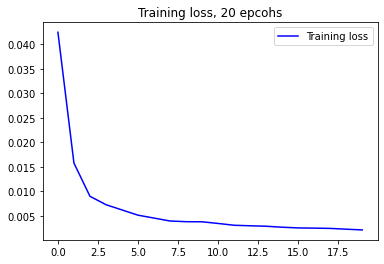

In [11]:
loss = history.history['loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training loss, " + str(NUM_EPOCH)+ " epcohs")
plt.legend()
plt.savefig("Train_loss_" + str(NUM_EPOCH) + "_epochs.pdf")
plt.show()

# Testing the fit of the model

In [13]:
part_60_days = train_df.tail(60)
# df2= part_60_days.append(test_df, ignore_index = True) # This one to exclude the newest values

df_test_new = pd.read_csv("../Tidsrekker/CBLTCUSD_testonly.csv", date_parser = True)
df_test_new['CBLTCUSD'] = pd.to_numeric(df_test_new['CBLTCUSD'])

df2 = part_60_days.append(df_test_new, ignore_index = True)
df2 = df2.drop(['DATE'], axis = 1)
df2.head()

,CBLTCUSD
0,133.74
1,135.28
2,133.18
3,129.39
4,132.05


In [14]:
inputs = scaler.transform(df2)
# inputs

In [15]:
X_test = []
Y_test = []
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    Y_test.append(inputs[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test.shape, Y_test.shape

((205, 60, 1), (205,))

In [16]:
Y_pred = model.predict(X_test)
# Y_pred, Y_test

In [17]:
scaler.scale_

array([0.00280978])

In [18]:
scale = 1/scaler.scale_
Y_test = Y_test*scale
Y_pred = Y_pred*scale

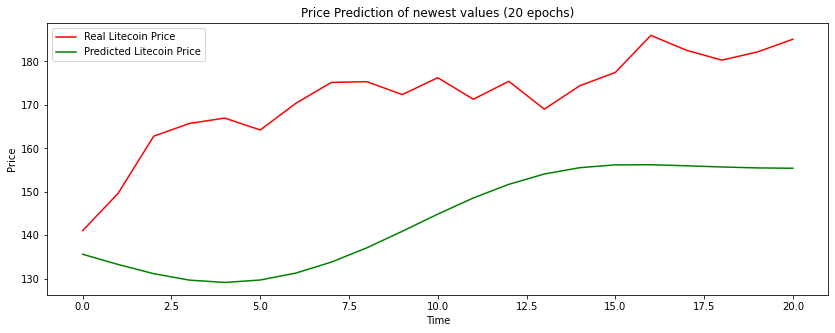

In [26]:
# This one is just to see how it looks like with the newest 21 days only
plt.figure(figsize=(14,5))
plt.plot(Y_test[-21:], color = 'red', label = 'Real Litecoin Price')
plt.plot(Y_pred[-21:], color = 'green', label = 'Predicted Litecoin Price')
plt.title('Price Prediction of newest values (' + str(NUM_EPOCH) + ' epochs)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig("NEWONLY_LSTM-pred-" + str(NUM_EPOCH) + ".pdf")
plt.show()


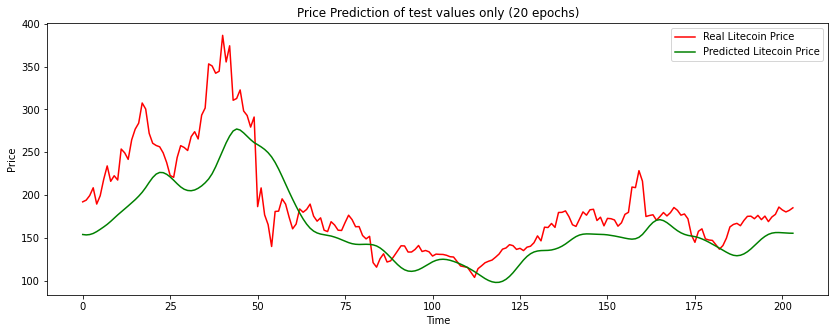

In [29]:
# This one is just to see how it looks like with the newest 21 days only
plt.figure(figsize=(14,5))
plt.plot(Y_test[-204:], color = 'red', label = 'Real Litecoin Price')
plt.plot(Y_pred[-204:], color = 'green', label = 'Predicted Litecoin Price')
plt.title('Price Prediction of test values only (' + str(NUM_EPOCH) + ' epochs)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig("all_test_LSTM-pred-" + str(NUM_EPOCH) + ".pdf")
plt.show()


In [32]:
latest_21_mean_error = np.mean(np.abs(Y_test[-21:] - Y_pred[-21:]))
test_mean_error = np.mean(np.abs(Y_test[-204:] - Y_pred[-204:]))
print("Latest 21 entries:", latest_21_mean_error)
print("All test entries:", test_mean_error)

Latest 21 entries: 28.56892904295404
All test entries: 56.27694275163748


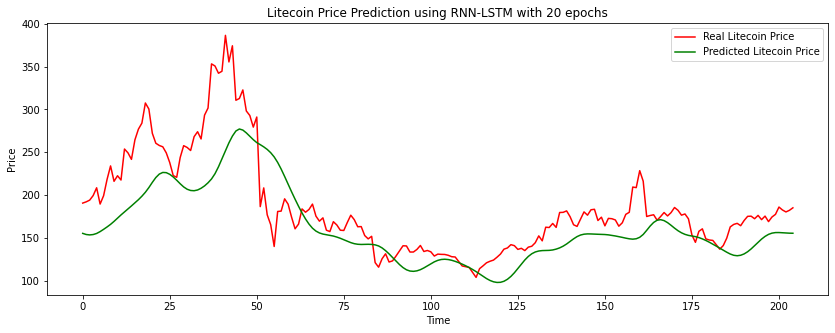

In [19]:
plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Litecoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Litecoin Price')
plt.title('Litecoin Price Prediction using RNN-LSTM with ' + str(NUM_EPOCH) + ' epochs')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig("LSTM-pred-" + str(NUM_EPOCH) + "-epochs.pdf")
plt.show()